In [1]:
from module.prepare import *
from itertools import product
from sklearn.externals import joblib
# import pygraphviz

D:\anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
help(GridSearchCV)

#### LGB

In [2]:
def LGBTuning(Xtrain,Ytrain):
    
    clf = lgb.LGBMClassifier(objective='binary',
                             silent=False,
                             verbose=1,
                             random_state=seed,
                             n_jobs=4,
#                              class_weight
                            )
    
    gridParams = {
        # step 1
#     'learning_rate': [0.01,0.05,0.1],
#     'boosting_type':['gbdt','goss'],
#     'n_estimators': [50,200,500],
#     'num_iterations':[200,400,1000],
        # step 1 fixed
    'learning_rate': [0.1], ### 0.1
    'boosting_type':['gbdt'], ### goss>gbdt
    'n_estimators': [300],
    'num_iterations':[2000], ### 2000
        # step 2
    'num_leaves': [680], ### 680
#     'max_bin':[127,255,511],
        # step 2 fixed
#     'num_leaves': [800],
    'max_bin':[256],
        # step 3
#     'max_depth':[7,8,9,10], ### missed
    'colsample_bytree' : [0.8], ### 0.8
    'subsample_freq':[1,2,3],
    'subsample' : [0.6,0.8,1],
    'reg_alpha' : [0,0.1,0.5],
    'reg_lambda' : [0,0.1,0.5],
    }

    print('default params\n',clf.get_params())

    grid = GridSearchCV(clf, gridParams,
                    scoring='roc_auc',
#                     refit=False,
                    verbose=3,
                    cv=5,
                    n_jobs=1)

    grid.fit(Xtrain,Ytrain)
    
    return grid

In [17]:
def LGBTuningSingle(X_train,X_test,Y_train,Y_test,params):
    
    [X_train, X_test, Y_train, Y_test] = train_test_split(X_train,Y_train,test_size=0.3)
    traindata = lgb.Dataset(X_train,Y_train)
    testdata = lgb.Dataset(X_test,Y_test)
    
    params = {    
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'roc-auc',
                'n_estimators':800,
                'learning_rate':0.08,
                'num_leaves':500, 
                'max_depth': -1,   
                'subsample': 0.9, 
                'colsample_bytree': 0.9, 
                'num_iterations':800,
            }
    
    clf = lgb.LGBMClassifier(boosting_type=params['boosting_type'],
                             max_depth=params['max_depth'],
                             objective=params['objective'],
                             num_leaves=params['num_leaves'],
                             learning_rate=params['learning_rate'],
                             subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'],
                             metric=params['metric'],
                             num_iterations=params['num_iterations'],
                             n_estimators=params['n_estimators'],
                             silent=False,
                             verbose=4
                            )

    print('default params\n',clf.get_params())

    clf.fit(X_train,Y_train,verbose=4)
    print('train',clf.score(X_train,Y_train))
    print('test',clf.score(X_test,Y_test))
    return clf

In [13]:
def LGBFit(X_train,X_test,Y_train,Y_test):
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

    params = {    
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'roc-auc',
#                 'nthread':6,
                'learning_rate':0.08,
                'num_leaves':300, 
                'max_depth': -1,   
                'subsample': 0.9, 
                'colsample_bytree': 0.9, 
                'feature_fraction': 1,
#                 'bagging_freq': 8,
# #                 'num_iterations':300,
#                 'min_data_in_leaf':2,
#                 'bagging_fraction': 0.8,
#                 'num_boost_round':3000,
            }

    cv_results = lgb.cv(params, lgb_train, nfold=5  
                        ,stratified=False, shuffle=True
                        ,seed=seed,
                        metrics=['auc','binary_logloss','mae']
                        ,verbose_eval=1)
    print('best n_estimators:', len(cv_results['auc-mean']))
    for k,v in cv_results.items():
        print('best cv score:', k, pd.Series(cv_results[k]).max())
    return [lgb,cv_results]

#### main

In [3]:
hyper_params = GetConfigure()
num_hyper_params = len(hyper_params)

generalize_ratio = 0.3
test_ratio = 0.3
cv = 1
mi_use = True

tuning_mode = True
if tuning_mode:
    cv = 1

cv_results = []

(20824,)

In [ ]:
[data,T] = ReadData()

# for i in 
for batch in range(cv):
    if mi_use==True:
        arr = ToMatrix(data,'sparse')
        [X_train,X_test,Y_train,Y_test] = MutualInformationFeatureSelection2(arr,data,generalize_ratio)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
    else:
        [X,Y] = ToMatrix(data,'dense')
        [X_train,X_test,Y_train,Y_test] = SplitDataset(X,Y,generalize_ratio)
        [X_train,X_test,Y_train,Y_test] = \
            RandomForestDimensionalityReduction(X_train,X_test,Y_train,Y_test)
    if tuning_mode:
        [Xtrain,Ytrain] = merge_train_test(X_train,X_test,Y_train,Y_test)
        grid = LGBTuning(Xtrain,Ytrain)
        cv_results.append(grid)

joblib.dump(grid,'./2-19-lgb-grid-tune4.m')

=============RETRIEVE TRIAN DATA=================
# DEBUG: # DEBUG: **************new dl 0***************
# DEBUG: READ SEQ FROM FILE
# DEBUG: READ CLUSTER FROM FILE
regex error 
regex error 
# DEBUG: READ PAIR FROM FILE
read line error 
# DEBUG: GENERATE NEGATIVE PAIR
# DEBUG: negative pair number 10412
INFO::count of negative pairs10412
# DEBUG: PAIR UNION
# DEBUG: EXTRACT FEATURES--PROTEIN
# DEBUG: EXTRACT FEATURES--RNA
# DEBUG: K-MER CALCULATION
# DEBUG: FEATURE UNION
# DEBUG: GARBAGE COLLECTION
MATRIX TRANSFORMATION
data shape 20824 8984
dimension ratio 0.803317 dimension remained 7217
INFO::mutual information sum 35.133866 select 0.988534
INFO::MI params 0.000500
rf raw data fit score 1.000000
select top K features importances 0.9838798044166548
dimension remained 3500
default params
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1, score=0.984, total=  57.6s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.5s remaining:    0.0s
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1, score=0.983, total=  57.9s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s
D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1, score=0.985, total=  59.6s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1, score=0.980, total=  58.7s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=1, score=0.985, total= 1.0min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2, score=0.983, total= 1.0min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2, score=0.581, total=  40.6s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2, score=0.583, total=  40.7s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2, score=0.599, total=  47.8s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=2, score=0.522, total=  49.9s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3, score=0.517, total=  48.2s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3, score=0.983, total= 1.0min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3, score=0.986, total= 1.0min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3, score=0.979, total= 1.0min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.6, subsample_freq=3, score=0.497, total=  57.3s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1, score=0.984, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1, score=0.983, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1, score=0.986, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1, score=0.980, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=1, score=0.986, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2, score=0.984, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2, score=0.983, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2, score=0.986, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2, score=0.980, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=2, score=0.985, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3, score=0.501, total=  42.1s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3, score=0.983, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3, score=0.986, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3, score=0.979, total= 1.1min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=0.8, subsample_freq=3, score=0.663, total=  53.7s
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1, score=0.984, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1, score=0.984, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1, score=0.986, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1, score=0.979, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=1, score=0.985, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2, score=0.984, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2, score=0.984, total= 1.4min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2, score=0.986, total= 1.6min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2, score=0.979, total= 1.4min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=2, score=0.985, total= 1.4min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3, score=0.984, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3, score=0.984, total= 1.2min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3, score=0.986, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3, score=0.979, total= 1.5min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0, subsample=1, subsample_freq=3, score=0.985, total= 1.5min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1, score=0.983, total= 1.4min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1, score=0.983, total= 1.4min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[CV]  boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1, score=0.985, total= 1.3min
[CV] boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.1, max_bin=256, n_estimators=300, num_iterations=2000, num_leaves=680, reg_alpha=0, reg_lambda=0.1, subsample=0.6, subsample_freq=1 


D:\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


#### test

In [ ]:
# DecisionTreePrefit(X_train,X_test,Y_train,Y_test)
[lgb,cv_results] = LGBFit(X_train,X_test,Y_train,Y_test)
WriteResult(DATASET,cv_results,conf,commons)

#### tuning

In [ ]:
clf1 = LGBTuningSingle(X_train,X_test,Y_train,Y_test)

In [ ]:
clf2 = LGBTuning(X_train,X_test,Y_train,Y_test)

In [ ]:
a = np.vstack([np.array(params),np.array(rank),np.array(score)])

a = a.T

a = np.array( list(sorted(a,key=lambda x:x[2],reverse=True)) )

a

In [32]:
list(grid.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_boosting_type',
 'param_learning_rate',
 'param_n_estimators',
 'param_num_iterations',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

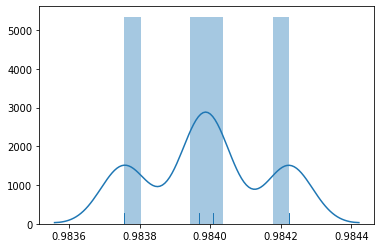

array([[0.9842239838679444,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 256, 'max_depth': 10, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 680}],
       [0.9842239838679444,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 256, 'max_depth': 10, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 800}],
       [0.9842239838679444,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 256, 'max_depth': 10, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 900}],
       [0.9842239838679444,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 256, 'max_depth': 10, 'n_estimators': 300, 'num_iterations': 2000, 'num_leaves': 1000}],
       [0.9840067524823375,
        {'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_bin': 256, 'max_depth': 9, 'n_estimators': 300, 'num_

In [14]:
sns.distplot(grid.cv_results_['mean_test_score'],rug=True,bins=10)
plt.show()
param_rank = np.array([grid.cv_results_['mean_test_score'],grid.cv_results_['params']]).T
a = sorted(param_rank,key=lambda x:x[0],reverse=True)
a = np.array(list(a))

a